<a href="https://colab.research.google.com/github/carson-edmonds/Stock_Prediction/blob/main/CEdmonds_AAI_511_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Loading the required libraries
import pandas as pd # Pandas for data manipulation
import seaborn as sns # Seaborn for visualizing. Note: we will also use one of the data sets
import matplotlib.pyplot as plt # Matplotlib for subplots
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
#from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV # Import train_test_split function

import tensorflow as tf
from tensorflow import keras

from sklearn import tree # Import Tree Classifiers
from sklearn.ensemble import RandomForestClassifier # Import Random Forest Classifiers
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from scipy.stats import randint # Generate random numbers
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn import svm

import os

In [ ]:
#@title Mounting your Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Loading data and viewing it

stocks = pd.read_csv('/content/drive/MyDrive/AAI 511/Assignments/all_stocks_5yr.csv')
stocks_shape = stocks.shape
print("Shape of the dataframe (row, col):", stocks_shape,"\r\n")

# Show dataframe
stocks

Shape of the dataframe (row, col): (619040, 7) 



,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [ ]:
#@title Checking for NULL values
#ad.dtypes
#ad.info()
#stocks.isnull().sum()

#print("Before dropping nan", stocks.shape)
stocks = stocks.dropna()
#print("After dropping nan", stocks.shape)

#Replacing null values with most frequent value
#Replace inplace
#ad.fillna(0,inplace=True)
stocks.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [ ]:
stocks.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
Name       object
dtype: object

In [ ]:
ordinalencoder = OrdinalEncoder()
stocks[['Name']] = ordinalencoder.fit_transform(stocks[['Name']])
stocks['date'] = stocks['date'].str.replace('-', '')
stocks['date'] = stocks['date'].astype(float)
stocks.dtypes

<ipython-input-111-5d8516249149>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks[['Name']] = ordinalencoder.fit_transform(stocks[['Name']])
<ipython-input-111-5d8516249149>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks['date'] = stocks['date'].str.replace('-', '')
<ipython-input-111-5d8516249149>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

date      float64
open      float64
high      float64
low       float64
close     float64
volume      int64
Name      float64
dtype: object

In [ ]:
AAL = stocks.loc[(stocks['Name'] == 0)]
AAL

,date,open,high,low,close,volume,Name
71611,20130208.0,45.07,45.350,45.000,45.08,1824755,0.0
71612,20130211.0,45.17,45.180,44.450,44.60,2915405,0.0
71613,20130212.0,44.81,44.950,44.500,44.62,2373731,0.0
71614,20130213.0,44.81,45.240,44.680,44.75,2052338,0.0
71615,20130214.0,44.72,44.780,44.360,44.58,3826245,0.0
...,...,...,...,...,...,...,...
72865,20180201.0,73.18,73.780,72.510,72.83,2008177,0.0
72866,20180202.0,72.32,72.760,71.220,71.25,1955697,0.0
72867,20180205.0,70.86,71.480,68.180,68.22,2860726,0.0
72868,20180206.0,66.96,68.830,66.130,68.45,4121239,0.0


In [ ]:
data = AAL[['close']].copy()
print(data.shape)
# Convert the dataset to a numpy array
#data = stocks.values.astype('float32')
data = data.values #.astype('float32')
print(data.shape)
#data_reshape = data.reshape(-1, 1)
print(data.shape)
# Split the data into training and testing sets
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size

print("before scale", data)
print("before scaling: shape", data.shape)
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

#print("after scale", data)
print("after scaling: shape", data.shape)


#data = scaler.inverse_transform(data)
#print('restored', data)

#train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]
train_data, test_data = data[0:train_size], data[train_size:len(data)]
#print(test_data.shape)
# Normalize the data
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#train_data = scaler.fit_transform(train_data)
#test_data = scaler.transform(test_data)

(1259, 1)
(1259, 1)
(1259, 1)
before scale [[45.08]
 [44.6 ]
 [44.62]
 ...
 [68.22]
 [68.45]
 [68.06]]
before scaling: shape (1259, 1)
after scaling: shape (1259, 1)


In [ ]:
# Create the training data
window_size = 12
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the training data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Create the testing data
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the testing data for LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

batch_size=64
# Calculate the number of batches per epoch
import math
n_batches = len(X_train) / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*n_batches)

In [ ]:
# Compile the model
#model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.SparseCategoricalAccuracy()])

def create_model():
# Build the LSTM model
  model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(50, input_shape=(window_size, 1)),
      tf.keras.layers.Dense(1)
  ])
  # Compile the model
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
# Train the model
model = create_model()
model.fit(X_train, y_train, epochs=200, batch_size=64, callbacks=[cp_callback])  #  epoch 300 default Pass callback to training

Epoch 1/200
14/14 [==============================] - 3s 7ms/step - loss: 0.0302
Epoch 2/200
14/14 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 4/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 5/200
13/14 [==========================>...] - ETA: 0s - loss: 0.0012    
Epoch 5: saving model to training_2/cp-0005.ckpt
14/14 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 6/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 7/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 8/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 9/200
14/14 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 10/200
13/14 [==========================>...] - ETA: 0s - loss: 9.5730e-04
Epoch 10: saving model to training_2/cp-0010.ckpt
14/14 [=========================

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
#loss, acc = model.evaluate(X_train, y_train, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
# Save the entire model as a `.keras` zip archive.
model.save('stocks_model.keras')

In [ ]:
saved_model = tf.keras.models.load_model('stocks_model.keras')

# Show the model architecture
#saved_model.summary()

In [ ]:
# Loads the weights
#model.load_weights(checkpoint_path)

# Re-evaluate the model
#loss, acc = model.evaluate(X_train, y_train, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
#print("x shape", X_test.shape)
#print("y shape", y_test.shape)

In [ ]:
#print(y_test)

12/12 [==============================] - 0s 2ms/step
predictions shape: (366, 1)


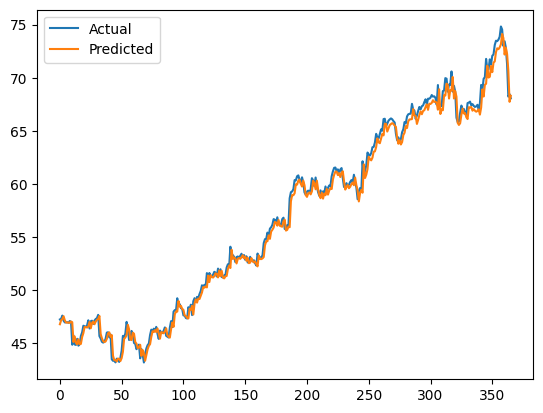

In [ ]:
# Evaluate the model on the test data
mse = model.evaluate(X_test, y_test)

# Make predictions on the test data
predictions = model.predict(X_test)
print("predictions shape:", predictions.shape)
#print(predictions)
# Reshape array1 to match the broadcast shape (366, 7)
#reshaped_pred = np.broadcast_to(predictions, (366, 7))
#reshaped_y_test = np.broadcast_to(y_test, (366, 7))

# Denormalize the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
#print(np.around(predictions, 1))
#print("actual", y_test)
pred = pd.DataFrame(predictions, columns = ['close'])
actual = pd.DataFrame(y_test, columns = ['close'])
# Plot the predictions and actual values
import matplotlib.pyplot as plt
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [ ]:
pred = pd.DataFrame(predictions)

In [ ]:
pred

,0
0,46.807076
1,47.180378
2,47.299812
3,47.562176
4,47.167236
...,...
361,72.837776
362,72.228035
363,70.652878
364,67.732323
